In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan

from Results.Standard_DDPM import (
    Linear_Variance_Scheduler,
    UNet,
    train_ddpm,        
    classifier_fn,       
    compute_activations, 
    load_mnist           
)

In [3]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [4]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

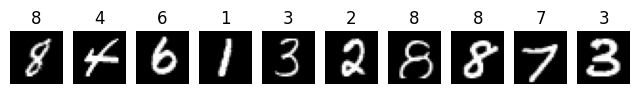

In [5]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

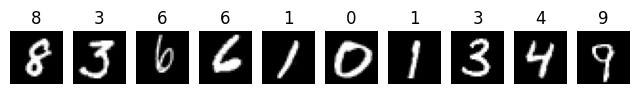

In [6]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

# Define dataloaders


In [7]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Forward process output

In [8]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)


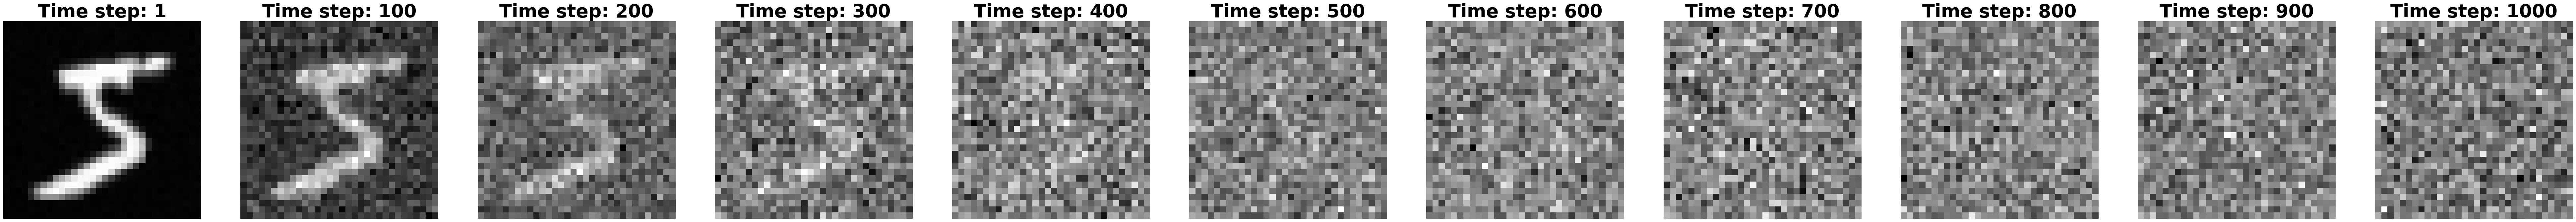

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False)

### Play with forward parameters

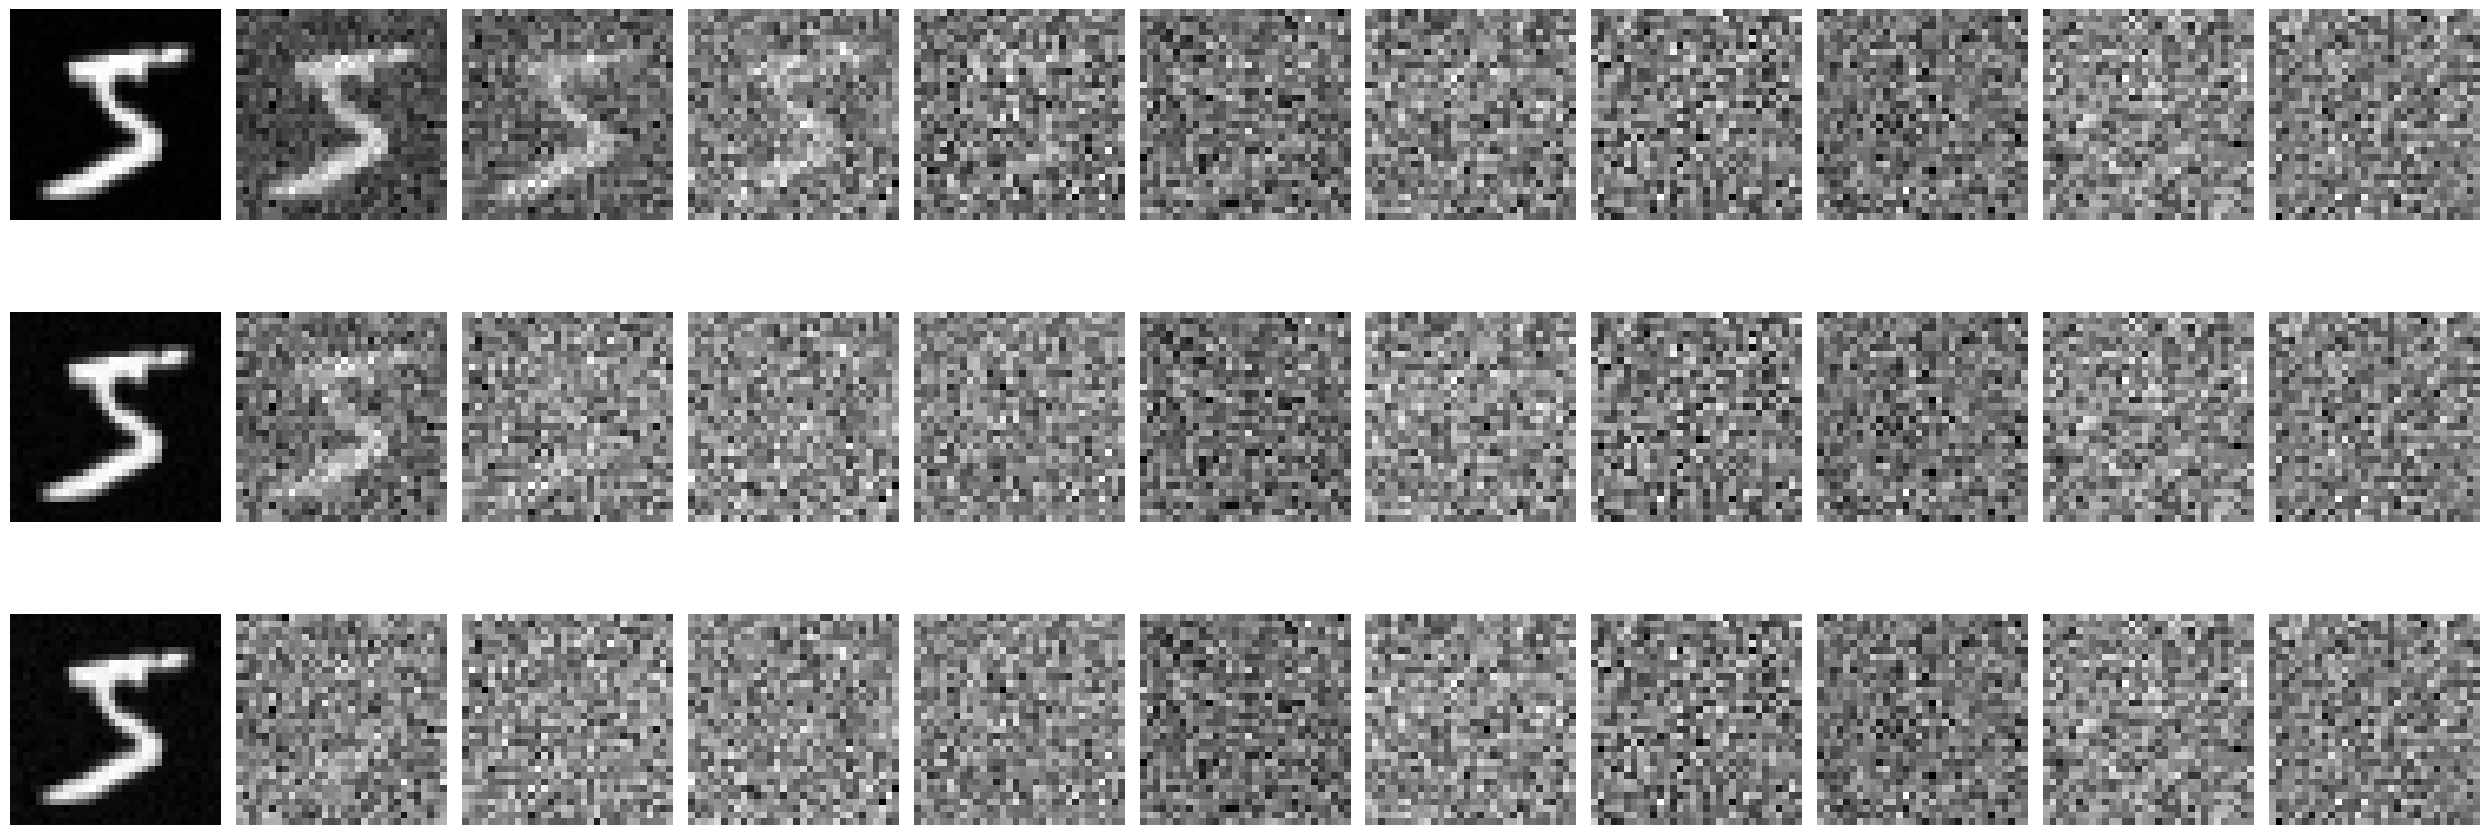

In [10]:
params_list = [
    {'time_steps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02},
    {'time_steps': 500, 'beta_start': 0.0005, 'beta_end': 0.05},
    {'time_steps': 200, 'beta_start': 0.001, 'beta_end': 0.1},
]

# Prepare data
get_img = training_dataset[0][0]
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# Generate noisy images for different parameter settings
fig, axes = plt.subplots(nrows=len(params_list), ncols=11, figsize=(25, 10))

for i, params in enumerate(params_list):
    scheduler = Linear_Variance_Scheduler(time_steps=params['time_steps'],
                                          beta_start=params['beta_start'],
                                          beta_end=params['beta_end'],
                                          device='cpu')
    noisy_img_stack = scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)
    
    for idx, img in enumerate(noisy_img_stack):
        axes[i, idx].imshow(img.squeeze(), cmap='gray')
        if idx == 0:
            axes[i, idx].set_ylabel(f"Steps: {params['time_steps']}\nBeta: [{params['beta_start']}, {params['beta_end']}]")
        axes[i, idx].axis(False)

plt.tight_layout()
plt.show()

# Set Up the model

In [11]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02, device=device)
model = UNet(t_emb_dim=256, device=device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# TRAINING

In [13]:
n_epochs = 20
training_loss, test_loss = train_ddpm(
    device=device,
    ddpm=ddpm,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    test_dataloader=test_dataloader,
    n_epochs=n_epochs
)

100%|██████████| 156/156 [00:05<00:00, 29.49it/s]


Epoch: 1/20	| Training loss: 0.0577 |   Test loss: 0.0306


100%|██████████| 156/156 [00:05<00:00, 29.55it/s]


Epoch: 2/20	| Training loss: 0.0283 |   Test loss: 0.0268


100%|██████████| 156/156 [00:11<00:00, 14.14it/s]


Epoch: 3/20	| Training loss: 0.0246 |   Test loss: 0.0233


100%|██████████| 156/156 [00:11<00:00, 14.15it/s]


Epoch: 4/20	| Training loss: 0.0224 |   Test loss: 0.0203


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 5/20	| Training loss: 0.0206 |   Test loss: 0.0207


100%|██████████| 156/156 [00:11<00:00, 14.15it/s]


Epoch: 6/20	| Training loss: 0.0195 |   Test loss: 0.0202


100%|██████████| 156/156 [00:11<00:00, 14.12it/s]


Epoch: 7/20	| Training loss: 0.0190 |   Test loss: 0.0185


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 8/20	| Training loss: 0.0183 |   Test loss: 0.0174


100%|██████████| 156/156 [00:11<00:00, 14.18it/s]


Epoch: 9/20	| Training loss: 0.0179 |   Test loss: 0.0180


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 10/20	| Training loss: 0.0175 |   Test loss: 0.0174


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 11/20	| Training loss: 0.0175 |   Test loss: 0.0179


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 12/20	| Training loss: 0.0172 |   Test loss: 0.0170


100%|██████████| 156/156 [00:11<00:00, 14.16it/s]


Epoch: 13/20	| Training loss: 0.0168 |   Test loss: 0.0164


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 14/20	| Training loss: 0.0166 |   Test loss: 0.0163


100%|██████████| 156/156 [00:11<00:00, 14.15it/s]


Epoch: 15/20	| Training loss: 0.0168 |   Test loss: 0.0165


100%|██████████| 156/156 [00:11<00:00, 14.16it/s]


Epoch: 16/20	| Training loss: 0.0163 |   Test loss: 0.0164


100%|██████████| 156/156 [00:11<00:00, 14.17it/s]


Epoch: 17/20	| Training loss: 0.0161 |   Test loss: 0.0161


100%|██████████| 156/156 [00:11<00:00, 14.18it/s]


Epoch: 18/20	| Training loss: 0.0161 |   Test loss: 0.0158


100%|██████████| 156/156 [00:11<00:00, 14.16it/s]


Epoch: 19/20	| Training loss: 0.0163 |   Test loss: 0.0157


100%|██████████| 156/156 [00:11<00:00, 14.16it/s]

Epoch: 20/20	| Training loss: 0.0159 |   Test loss: 0.0156


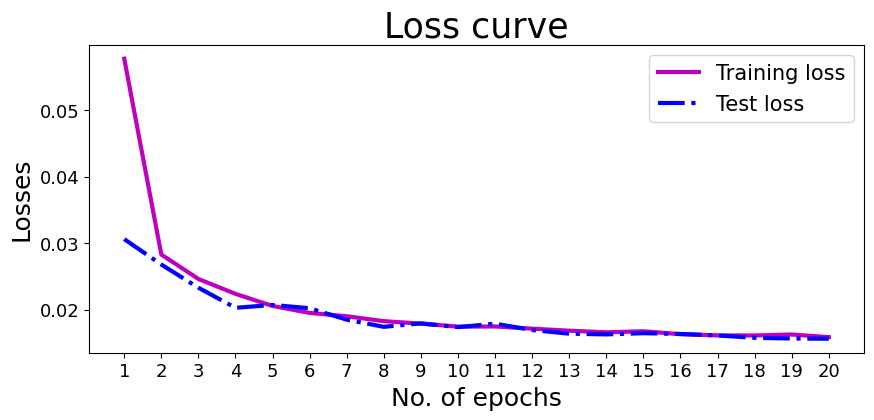

In [19]:
N = np.arange(n_epochs) + 1
plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

# Save and Load the model

In [31]:
# Save the model
torch.save(model.state_dict(), 'Models/ddpm_Standard.pth')

In [ ]:
model = UNet(t_emb_dim=256, device=device)
# Load the saved state dictionary
model.load_state_dict(torch.load('Models/ddpm_Standard.pth'))

# Set the model to evaluation mode
model.eval()

# Reverse process

1000it [00:06, 154.15it/s]


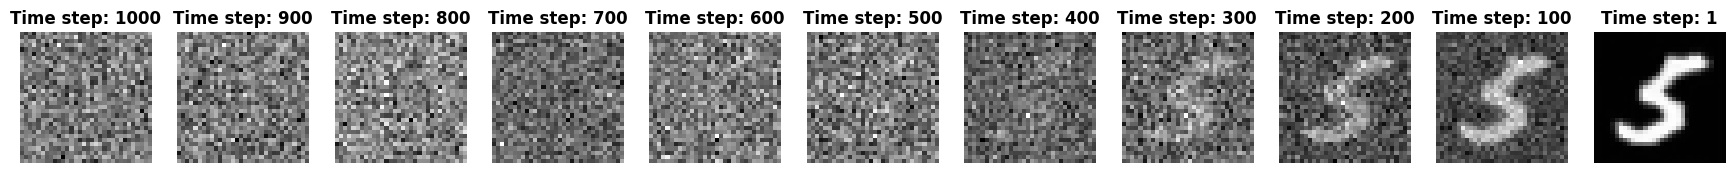

In [20]:
x_samples, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))
j = 0
for ax in axis.ravel():
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1
plt.show()

# Random sampling from noise

1000it [00:22, 44.64it/s]


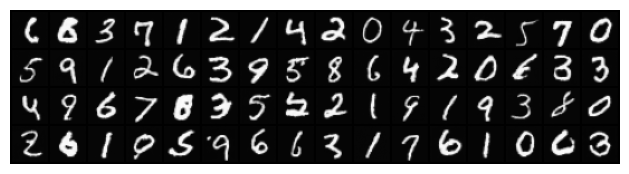

In [29]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.show()

# Evaluate FID with classifier

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=1000, channels=1, img_size=32)


In [27]:
sampled_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)
sampled_imgs_np = sampled_imgs_resized.cpu().numpy()
sampled_imgs_np = (sampled_imgs_np * 0.5) + 0.5
sampled_imgs_np = np.clip(sampled_imgs_np, 0, 1)
sampled_imgs_np = np.transpose(sampled_imgs_np, (0, 2, 3, 1))
sampled_imgs_tf = tf.convert_to_tensor(sampled_imgs_np, dtype=tf.float32)

In [28]:
# Load the pre-trained MNIST classifier
MNIST_MODULE = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
mnist_classifier_fn = tfhub.load(MNIST_MODULE)

mnist_images_tf = load_mnist()
activations_real = compute_activations(
    mnist_images_tf, num_batches=1, classifier_fn=classifier_fn)

activations_fake = compute_activations(
    sampled_imgs_tf, num_batches=1, classifier_fn=classifier_fn)

fid = tfgan.eval.frechet_classifier_distance_from_activations(
    activations_real, activations_fake)

print(f"FID: {fid.numpy()}")


FID: 3.431985378265381
